In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
cybersec = pd.read_excel(r".\Global_Cybersecurity_Threats.xlsx")
cybersec.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169.0,Hacker Group,Unpatched Software,VPN,63.0
1,China,2019,Ransomware,Retail,NaN,295961.0,Hacker Group,Unpatched Software,Firewall,71.0
2,India,2017,Man-in-the-Middle,IT,38.65,605895.0,Hacker Group,Weak Passwords,VPN,20.0
3,UK,2024,Ransomware,Telecommunications,41.44,659320.0,Nation-state,Social Engineering,AI-based Detection,7.0
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682.0,NaN,Social Engineering,VPN,68.0


In [3]:
cybersec.dtypes

Country                                 object
Year                                     int64
Attack Type                             object
Target Industry                         object
Financial Loss (in Million $)          float64
Number of Affected Users               float64
Attack Source                           object
Security Vulnerability Type             object
Defense Mechanism Used                  object
Incident Resolution Time (in Hours)    float64
dtype: object

##### Correct data type

In [4]:
cybersec['Year'] = pd.to_datetime(cybersec['Year'], errors='coerce').dt.year
categorical_cols = [
    'Attack Type',
    'Target Industry',
    'Attack Source',
    'Security Vulnerability Type',
    'Defense Mechanism Used'
]
for col in categorical_cols:
    cybersec[col] = cybersec[col].astype('category')

print(cybersec.dtypes)

Country                                  object
Year                                      int32
Attack Type                            category
Target Industry                        category
Financial Loss (in Million $)           float64
Number of Affected Users                float64
Attack Source                          category
Security Vulnerability Type            category
Defense Mechanism Used                 category
Incident Resolution Time (in Hours)     float64
dtype: object


##### Check for NAs

In [5]:
missing = cybersec.isnull().sum()
print(missing)

Country                                  0
Year                                     0
Attack Type                             98
Target Industry                          0
Financial Loss (in Million $)          129
Number of Affected Users               102
Attack Source                           79
Security Vulnerability Type             77
Defense Mechanism Used                   0
Incident Resolution Time (in Hours)     76
dtype: int64


##### Conduct the Little's MCAR test 

In [6]:
from pyampute.exploration.mcar_statistical_tests import MCARTest

In [7]:
#Select columns with missing values to test
subset = cybersec[['Attack Type',
                   'Financial Loss (in Million $)',
                   'Number of Affected Users',
                   'Security Vulnerability Type',
                   'Attack Source',
                   'Incident Resolution Time (in Hours)']]
# Convert categorical variables to numerical codes
subset_encoded = subset.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'category' else col)

In [8]:
mt = MCARTest(method="little")
print(mt.little_mcar_test(subset_encoded))

0.8203963075682463


##### The p-value of the test is 0.82, so we can accept the null hypothesis. Which indicates that the missing pattern of the data is Missing Completely At Random. 

##### Because the missingness is unrelated to the data, we can simply drop all the rows with NA values.

In [9]:
cybersec_cleaned = cybersec.dropna()
cybersec_cleaned.isnull().sum()

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64

##### Check for outliers

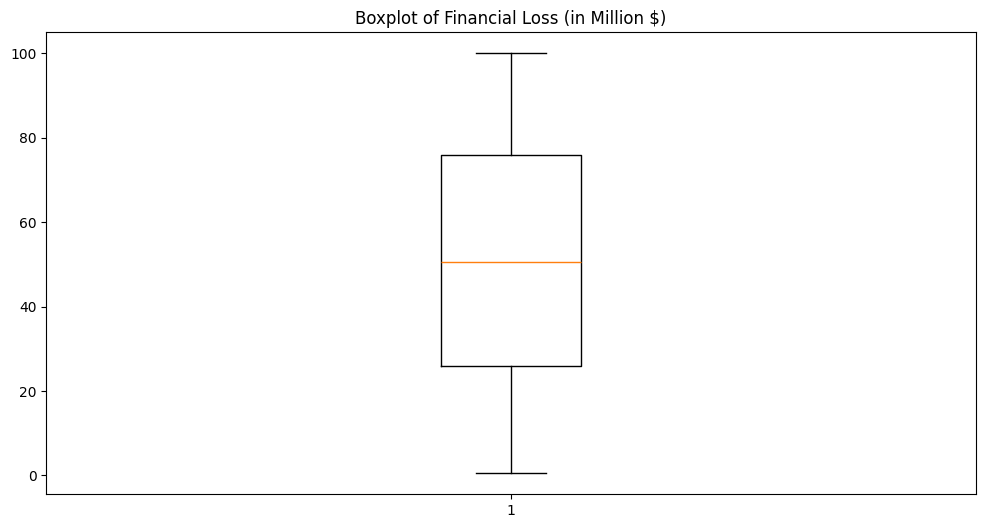

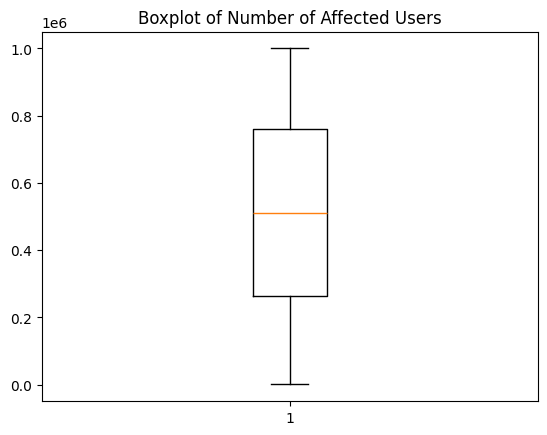

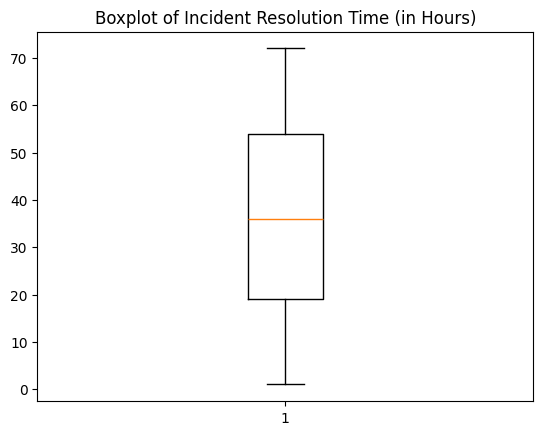

In [9]:
numeric_features = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']
plt.figure(figsize=(12, 6))
for feature in numeric_features:
    plt.boxplot(cybersec_cleaned[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()


TIME SERIES ANALYSIS

Cybersecurity Threats Over the Years

In [4]:
incident_trends = cybersec.groupby('Year', observed=False).size().reset_index(name='Incident Count')
x = incident_trends['Year']
y = incident_trends['Incident Count']
coef = np.polyfit(x, y, 1)
trend = np.poly1d(coef)
incident_trends['Trend'] = trend(x)

# Find peak point
max_idx = incident_trends['Incident Count'].idxmax()
max_year = incident_trends.loc[max_idx, 'Year']
max_value = incident_trends.loc[max_idx, 'Incident Count']

fig = px.line(incident_trends, x='Year', y='Incident Count',
              title='Number of Incidents Over Time',
              labels={'Year': 'Year', 'Incident Count': 'Number of Incidents'},
              markers=True)

# Insert Tendency line
fig.add_trace(go.Scatter(
    x=incident_trends['Year'],
    y=incident_trends['Trend'],
    mode='lines',
    name='Trend Line',
    line=dict(color='orange', dash='dash')
))

# Insert Peak
fig.add_trace(go.Scatter(
    x=[max_year],
    y=[max_value],
    mode='markers+text',
    name='Peak',
    marker=dict(color='red', size=10),
    text=[f"Peak: {max_value}"],
    textposition='top center'
))
fig.update_layout(title_x=0.5, xaxis=dict(tickmode='linear'), width=800, height=500)
fig.show()


In [10]:
# Tổng thiệt hại theo quốc gia
country_impact = cybersec.groupby('Country')['Financial Loss (in Million $)'].sum().reset_index()

# Lấy top 10 quốc gia thiệt hại cao nhất
top10 = country_impact.sort_values(by='Financial Loss (in Million $)', ascending=False).head(10)

# Vẽ bản đồ choropleth
fig = px.choropleth(top10,
                    locations='Country',
                    locationmode='country names',
                    color='Financial Loss (in Million $)',
                    hover_name='Country',
                    color_continuous_scale='Reds',
                    title='Top 10 Quốc Gia Bị Thiệt Hại Tài Chính Nặng Nhất Do Tấn Công Mạng')

fig.update_geos(projection_type="natural earth")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

C:\Users\LAPTOP ACER\AppData\Local\Temp\ipykernel_22836\1500681834.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cybersec_cleaned['Development_Status'] = cybersec_cleaned['Country'].apply(lambda x: 'Developed' if x in developed_countries else 'Developing')
C:\Users\LAPTOP ACER\AppData\Local\Temp\ipykernel_22836\1500681834.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=impact_by_status, x='Development_Status', y='Financial Loss (in Million $)', palette='coolwarm')


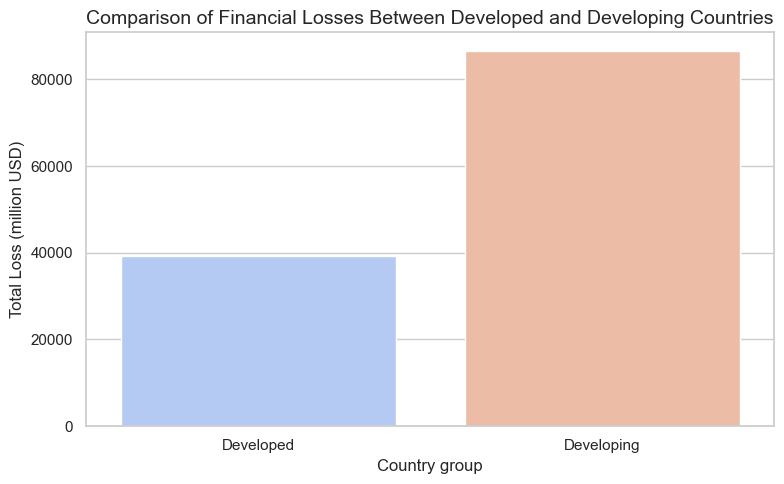

In [12]:
# Tạo danh sách quốc gia phát triển
developed_countries = ['UK', 'France', 'Japan']


# Tạo cột mới: Developed / Developing
cybersec_cleaned['Development_Status'] = cybersec_cleaned['Country'].apply(lambda x: 'Developed' if x in developed_countries else 'Developing')


# Tính tổng thiệt hại theo nhóm quốc gia
impact_by_status = cybersec_cleaned.groupby('Development_Status')['Financial Loss (in Million $)'].sum().reset_index()


# Vẽ biểu đồ so sánh
plt.figure(figsize=(8, 5))
sns.barplot(data=impact_by_status, x='Development_Status', y='Financial Loss (in Million $)', palette='coolwarm')
plt.title('Comparison of Financial Losses Between Developed and Developing Countries', fontsize=14)
plt.xlabel('Country group')
plt.ylabel('Total Loss (million USD)')
plt.tight_layout()
plt.show()

Các ngành có trong dữ liệu: ['Education', 'Retail', 'IT', 'Telecommunications', 'Government', 'Banking', 'Healthcare']
Categories (7, object): ['Banking', 'Education', 'Government', 'Healthcare', 'IT', 'Retail', 'Telecommunications']


C:\Users\LAPTOP ACER\AppData\Local\Temp\ipykernel_13532\1145754771.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  industry_stats = cybersec.groupby('Target Industry').agg({


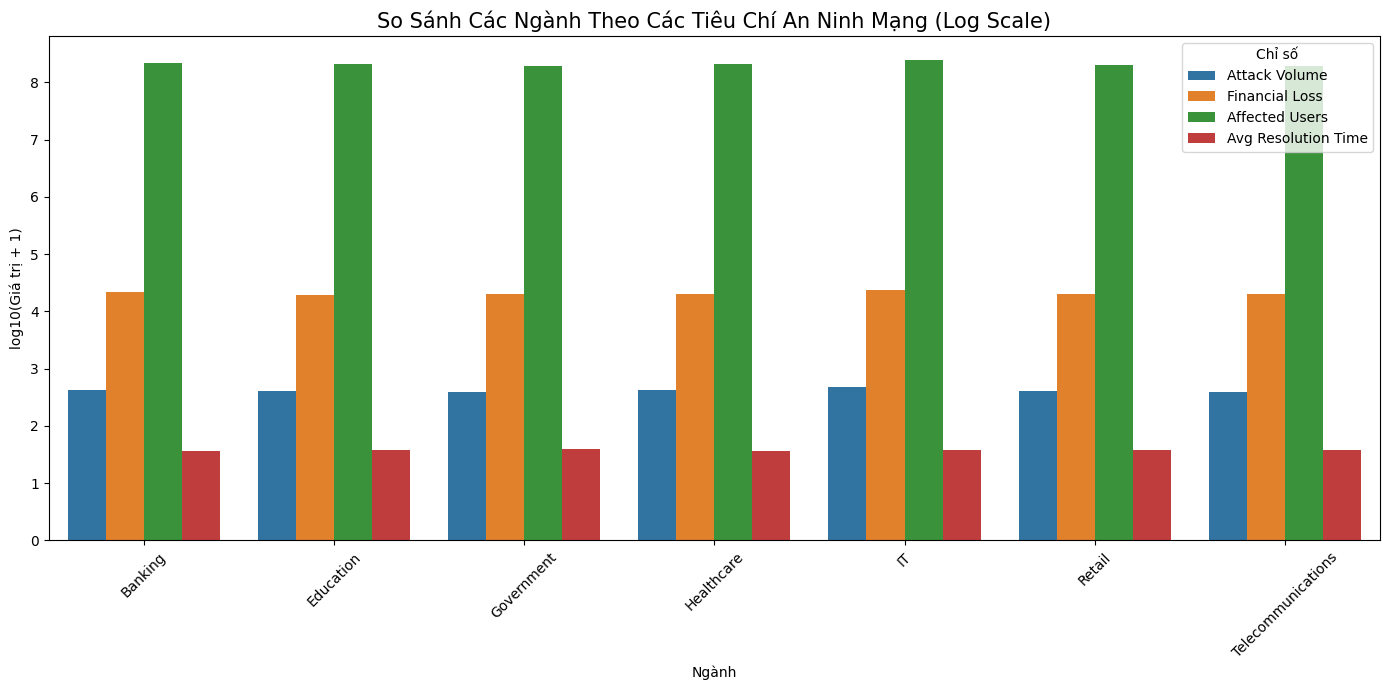

In [8]:
# Kiểm tra cột Target Industry có tồn tại không
if 'Target Industry' not in cybersec.columns:
    print("Không tìm thấy cột 'Target Industry' trong dữ liệu!")
else:
    print("Các ngành có trong dữ liệu:", cybersec['Target Industry'].unique())

    # Tính tổng các chỉ số theo ngành
    industry_stats = cybersec.groupby('Target Industry').agg({
        'Financial Loss (in Million $)': 'sum',
        'Number of Affected Users': 'sum',
        'Incident Resolution Time (in Hours)': 'mean',
        'Attack Type': 'count'  # volume (số cuộc tấn công)
    }).reset_index()

    # Đổi tên cột cho dễ nhìn
    industry_stats.rename(columns={
        'Attack Type': 'Attack Volume',
        'Financial Loss (in Million $)': 'Financial Loss',
        'Number of Affected Users': 'Affected Users',
        'Incident Resolution Time (in Hours)': 'Avg Resolution Time'
    }, inplace=True)

    # Chuyển dữ liệu sang dạng "long" để vẽ grouped bar chart
    industry_melted = industry_stats.melt(id_vars='Target Industry',
                                          value_vars=['Attack Volume', 'Financial Loss', 'Affected Users', 'Avg Resolution Time'],
                                          var_name='Metric',
                                          value_name='Value')

    # Thêm cột log để xử lý lệch thang đo
    industry_melted['Log Value'] = np.log10(industry_melted['Value'] + 1)

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 7))
    sns.barplot(data=industry_melted, x='Target Industry', y='Log Value', hue='Metric')
    plt.title('So Sánh Các Ngành Theo Các Tiêu Chí An Ninh Mạng (Log Scale)', fontsize=15)
    plt.xlabel('Ngành')
    plt.ylabel('log10(Giá trị + 1)')
    plt.xticks(rotation=45)
    plt.legend(title='Chỉ số')
    plt.tight_layout()
    plt.show()


C:\Users\IEC\AppData\Local\Temp\ipykernel_19316\4144274998.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  industry_attack_counts = cybersec_cleaned.groupby(['Attack Type', 'Target Industry']).size().unstack(fill_value=0)


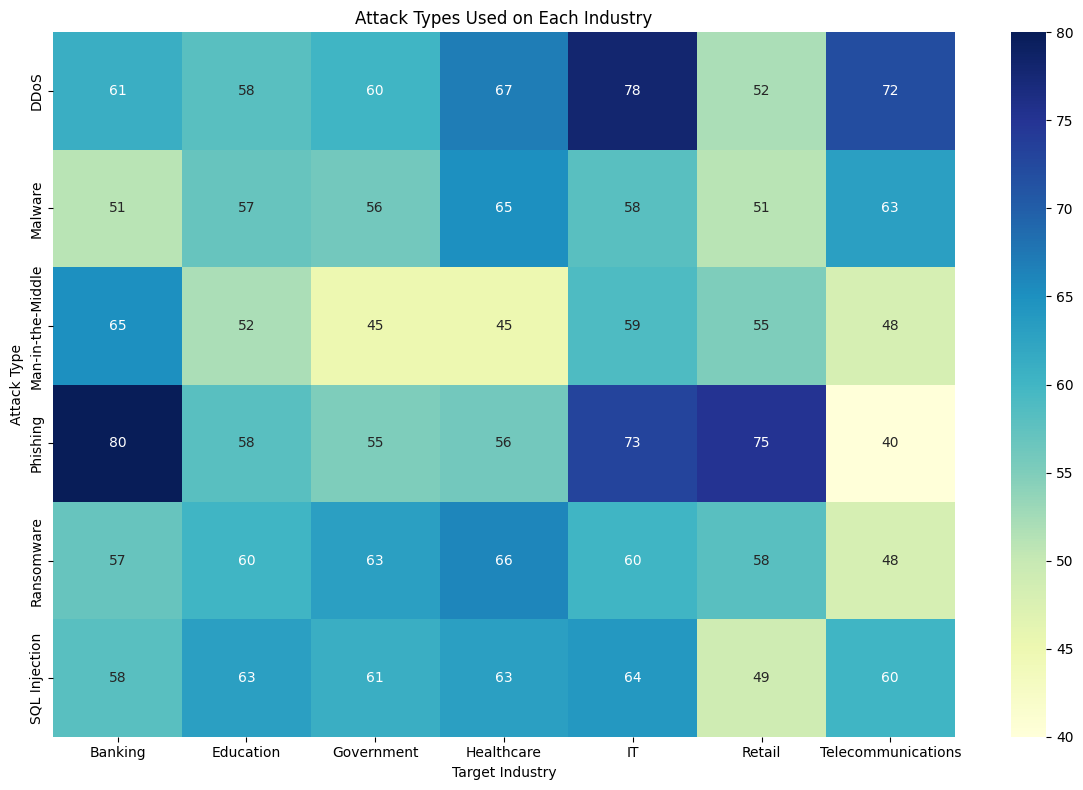

In [12]:
# Group by Attack Type and Target Industry, then count occurrences
industry_attack_counts = cybersec_cleaned.groupby(['Attack Type', 'Target Industry']).size().unstack(fill_value=0)




# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(industry_attack_counts, annot=True, fmt='d', cmap='YlGnBu')




plt.title('Attack Types Used on Each Industry')
plt.xlabel('Target Industry')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

C:\Users\IEC\AppData\Local\Temp\ipykernel_7220\498369034.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_data = cybersec_cleaned.groupby("Attack Type")["Financial Loss (in Million $)"].sum().sort_values(ascending=False)
C:\Users\IEC\AppData\Local\Temp\ipykernel_7220\498369034.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_data = cybersec_cleaned.groupby("Attack Type")["Incident Resolution Time (in Hours)"].sum().sort_values(ascending=False)
C:\Users\IEC\AppData\Local\Temp\ipykernel_7220\498369034.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in

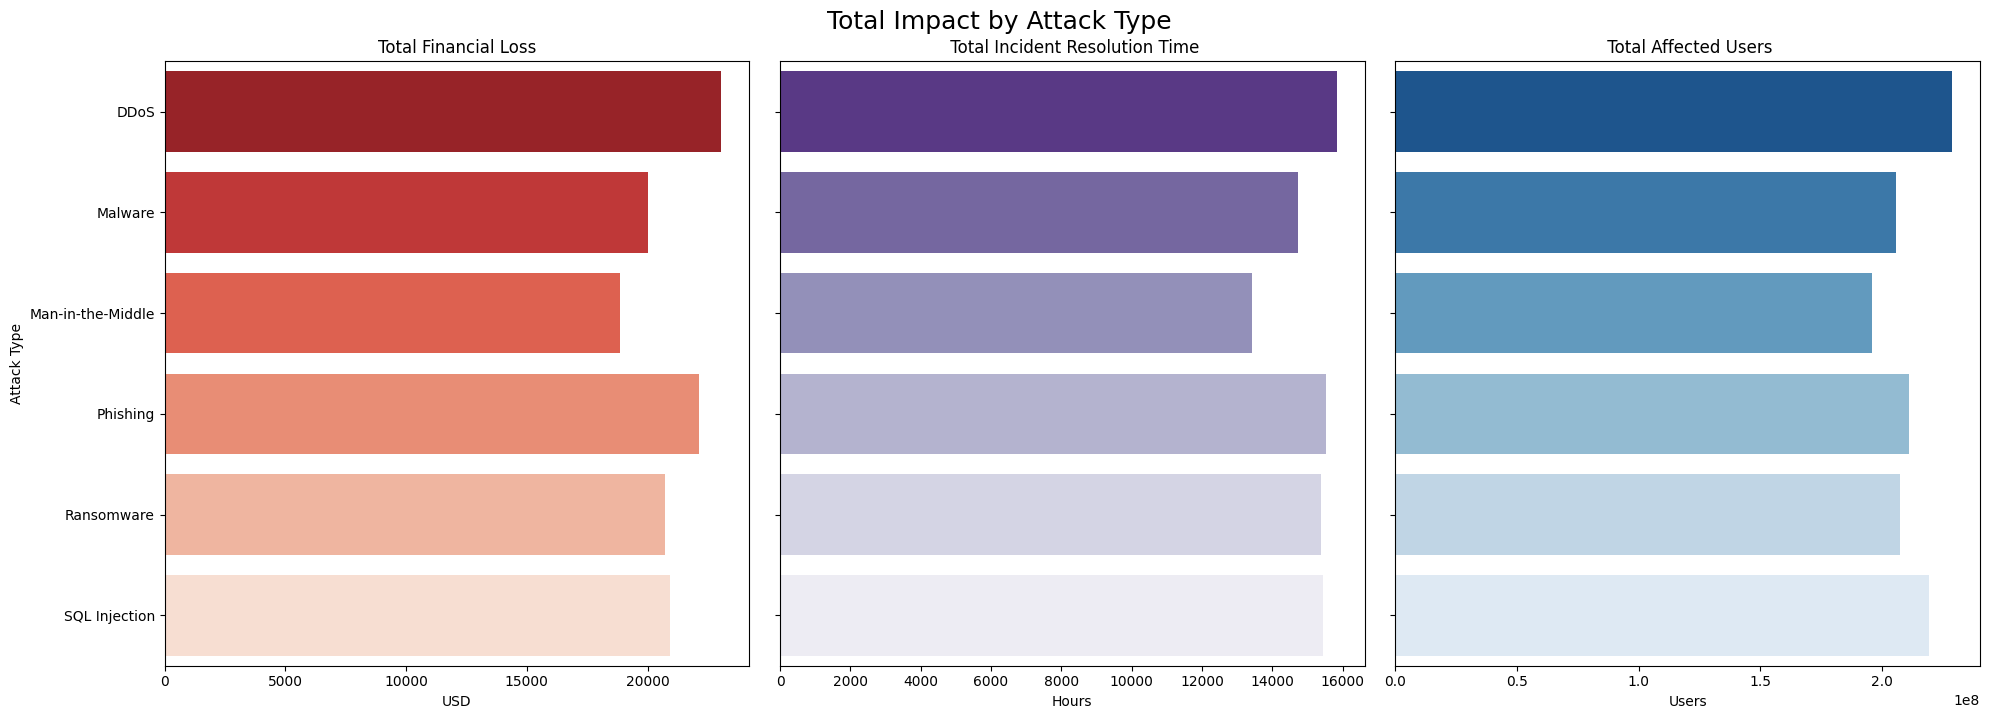

In [10]:
# Prepare data
loss_data = cybersec_cleaned.groupby("Attack Type")["Financial Loss (in Million $)"].sum().sort_values(ascending=False)
time_data = cybersec_cleaned.groupby("Attack Type")["Incident Resolution Time (in Hours)"].sum().sort_values(ascending=False)
users_data = cybersec_cleaned.groupby("Attack Type")["Number of Affected Users"].sum().sort_values(ascending=False)

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# Chart 1: Financial Loss
sns.barplot(x=loss_data.values, y=loss_data.index, ax=axes[0], palette="Reds_r")
axes[0].set_title("Total Financial Loss")
axes[0].set_xlabel("USD")
axes[0].set_ylabel("Attack Type")

# Chart 2: Resolution Time
sns.barplot(x=time_data.values, y=time_data.index, ax=axes[1], palette="Purples_r")
axes[1].set_title(" Total Incident Resolution Time")
axes[1].set_xlabel("Hours")
axes[1].set_ylabel("")

# Chart 3: Affected Users
sns.barplot(x=users_data.values, y=users_data.index, ax=axes[2], palette="Blues_r")
axes[2].set_title(" Total Affected Users")
axes[2].set_xlabel("Users")
axes[2].set_ylabel("")

# Layout tweaks
plt.tight_layout()
plt.suptitle(" Total Impact by Attack Type", fontsize=18, y=1.02)
plt.show()

C:\Users\IEC\AppData\Local\Temp\ipykernel_19316\4206135983.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attack_success = cybersec_cleaned.groupby("Attack Type").agg({


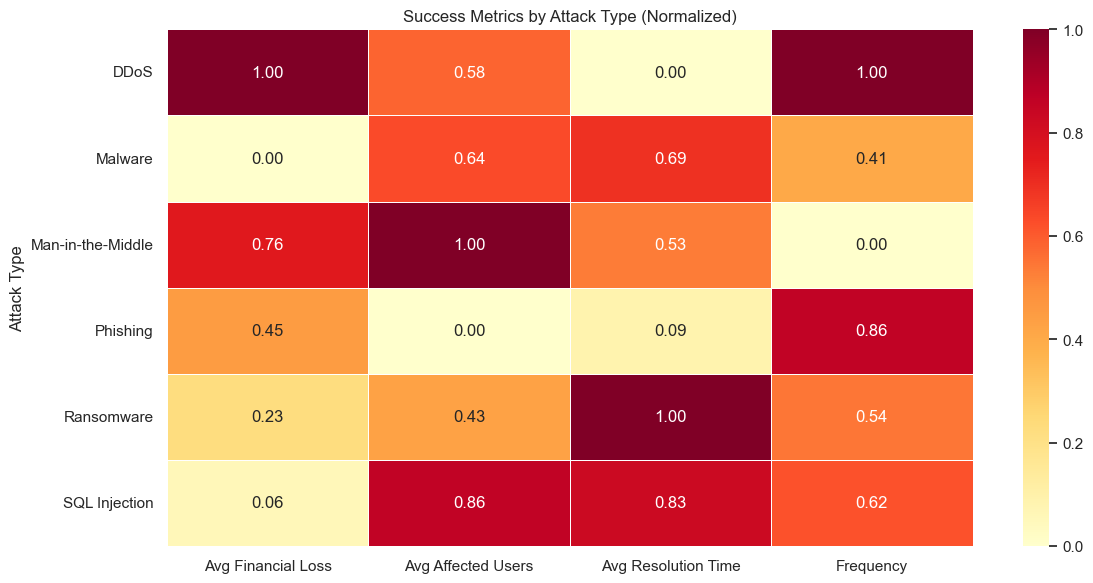

In [14]:

# Group and calculate success metrics
attack_success = cybersec_cleaned.groupby("Attack Type").agg({
    "Financial Loss (in Million $)": "mean",
    "Number of Affected Users": "mean",
    "Incident Resolution Time (in Hours)": "mean",
    "Attack Type": "count"  # Frequency
}).rename(columns={
    "Financial Loss (in Million $)": "Avg Financial Loss",
    "Number of Affected Users": "Avg Affected Users",
    "Incident Resolution Time (in Hours)": "Avg Resolution Time",
    "Attack Type": "Frequency"
})


# Normalize data for better heatmap contrast (optional)
attack_success_normalized = (attack_success - attack_success.min()) / (attack_success.max() - attack_success.min())


# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(attack_success_normalized, annot=True, cmap="YlOrRd", linewidths=0.5, fmt=".2f")
plt.title("Success Metrics by Attack Type (Normalized)")
plt.ylabel("Attack Type")
plt.tight_layout()
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7864\639424547.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


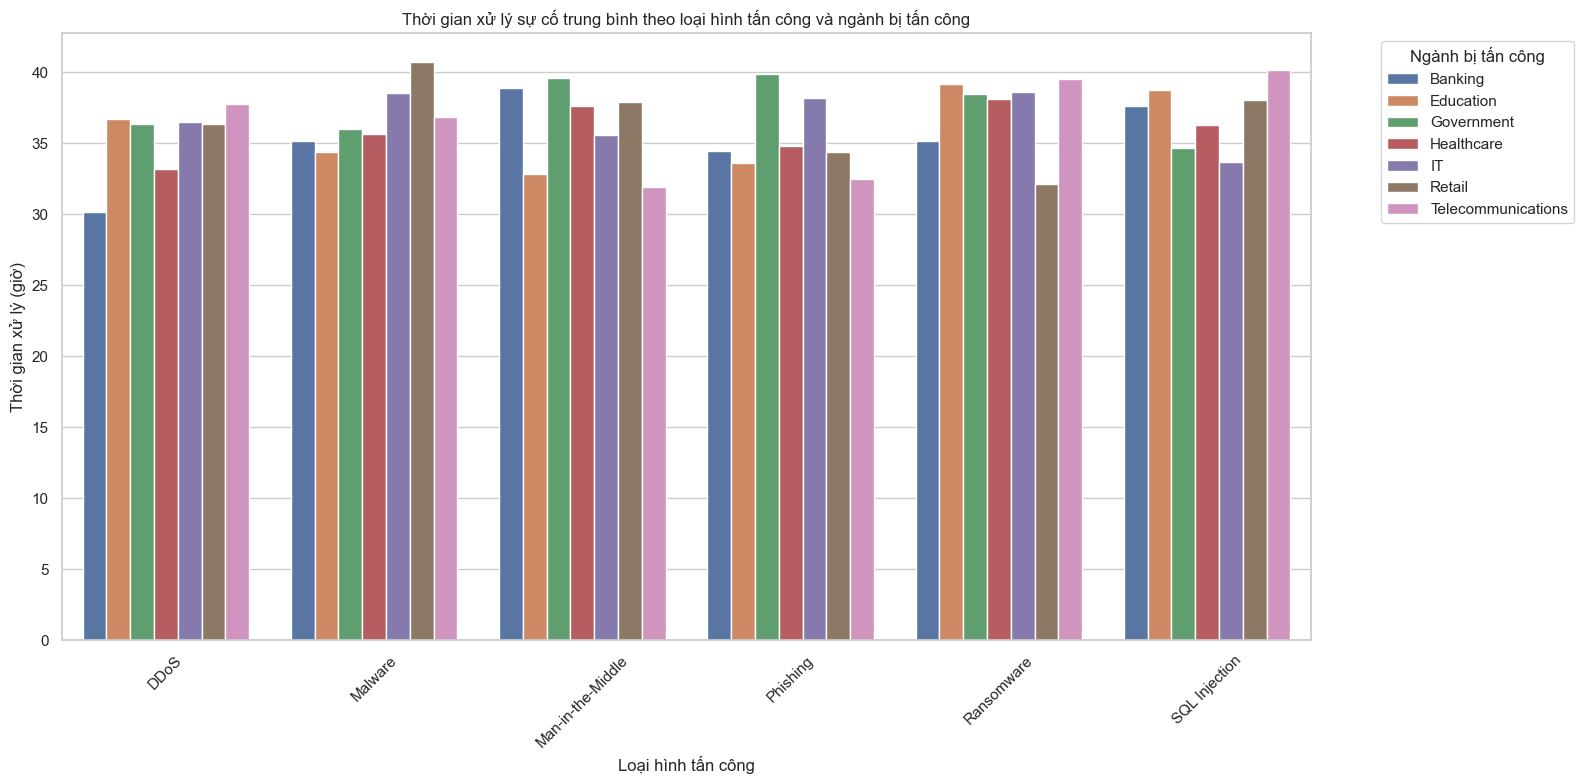

In [11]:
# Thiết lập kích thước và style
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

# Biểu đồ barplot: Thời gian xử lý trung bình theo Attack Type và Target Industry
sns.barplot(
    data=cybersec_cleaned,
    x="Attack Type",
    y="Incident Resolution Time (in Hours)",
    hue="Target Industry",
    estimator="mean",
    ci=None
)

# Gắn tiêu đề và nhãn trục
plt.title("Thời gian xử lý sự cố trung bình theo loại hình tấn công và ngành bị tấn công")
plt.ylabel("Thời gian xử lý (giờ)")
plt.xlabel("Loại hình tấn công")
plt.xticks(rotation=45)
plt.legend(title="Ngành bị tấn công", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_9732\3282740756.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = cybersec_cleaned.groupby(["Country", "Attack Type"]).size().reset_index(name="Attack Count")


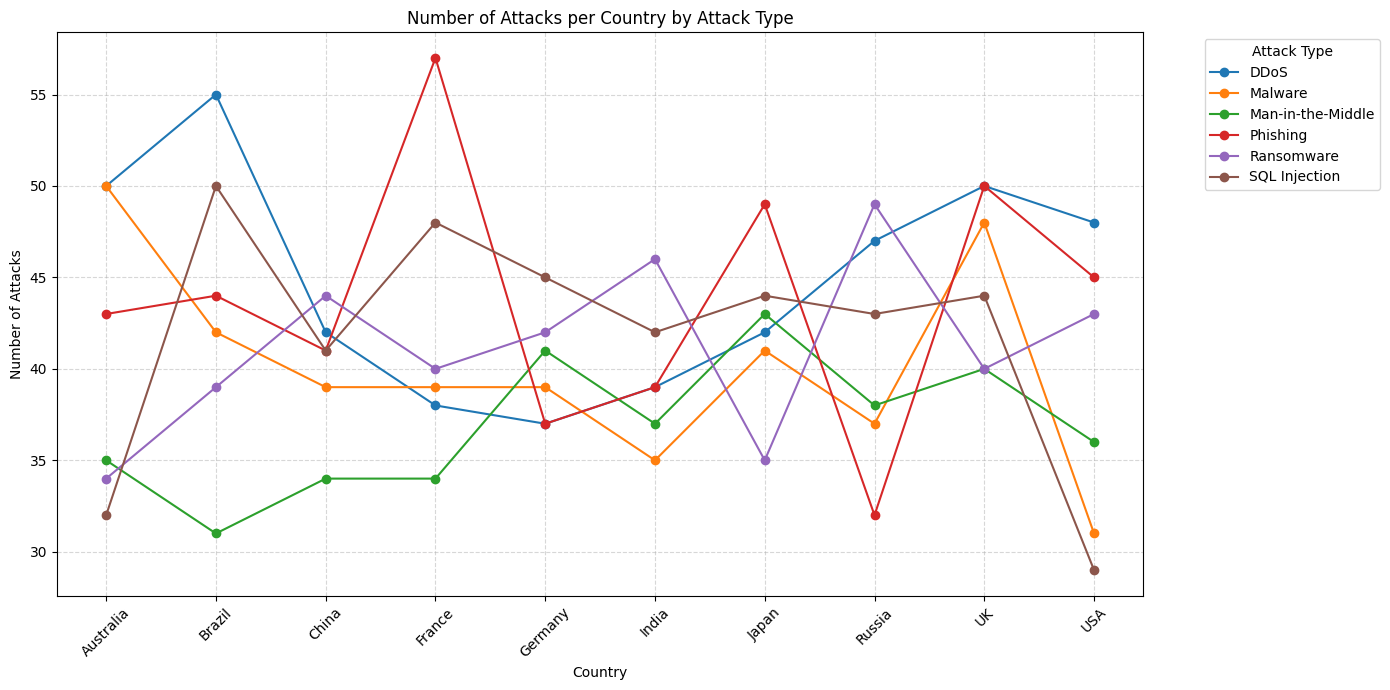

In [11]:
grouped = cybersec_cleaned.groupby(["Country", "Attack Type"]).size().reset_index(name="Attack Count")

# Pivot để tạo định dạng phù hợp cho line chart
pivot_df = grouped.pivot(index="Country", columns="Attack Type", values="Attack Count").fillna(0)

# Vẽ biểu đồ line chart
plt.figure(figsize=(14, 7))
for attack_type in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[attack_type], marker='o', label=attack_type)

plt.title("Number of Attacks per Country by Attack Type")
plt.xlabel("Country")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)
plt.legend(title="Attack Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_9732\1490332733.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = cybersec_cleaned.groupby("Defense Mechanism Used")["Incident Resolution Time (in Hours)"].mean().reset_index()
C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_9732\1490332733.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = grouped.pivot_table(index="Defense Mechanism Used", values="Incident Resolution Time (in Hours)")


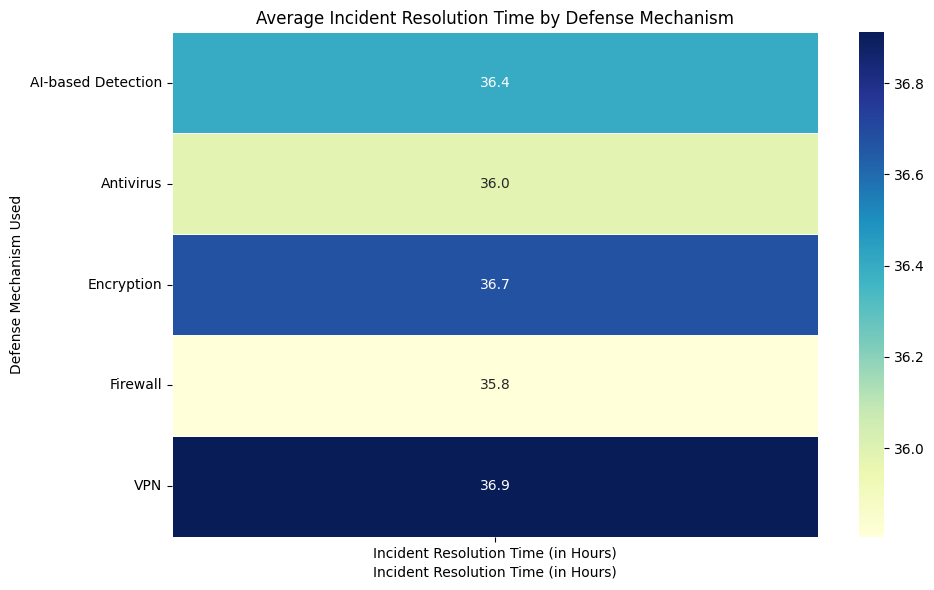

In [9]:
# Nhóm và tính trung bình thời gian xử lý theo từng cơ chế phòng thủ
grouped = cybersec_cleaned.groupby("Defense Mechanism Used")["Incident Resolution Time (in Hours)"].mean().reset_index()

# Chuyển thành pivot để dùng heatmap
pivot_df = grouped.pivot_table(index="Defense Mechanism Used", values="Incident Resolution Time (in Hours)")

# Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=0.5)

plt.title("Average Incident Resolution Time by Defense Mechanism")
plt.xlabel("Incident Resolution Time (in Hours)")
plt.ylabel("Defense Mechanism Used")
plt.tight_layout()
plt.show()


C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_9732\2984821243.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attack_type_frequency = cybersec_cleaned.groupby('Attack Type').size().reset_index(name='Number of Incidents')
C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_9732\2984821243.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=attack_type_frequency, x='Number of Incidents', y='Attack Type', palette='viridis')


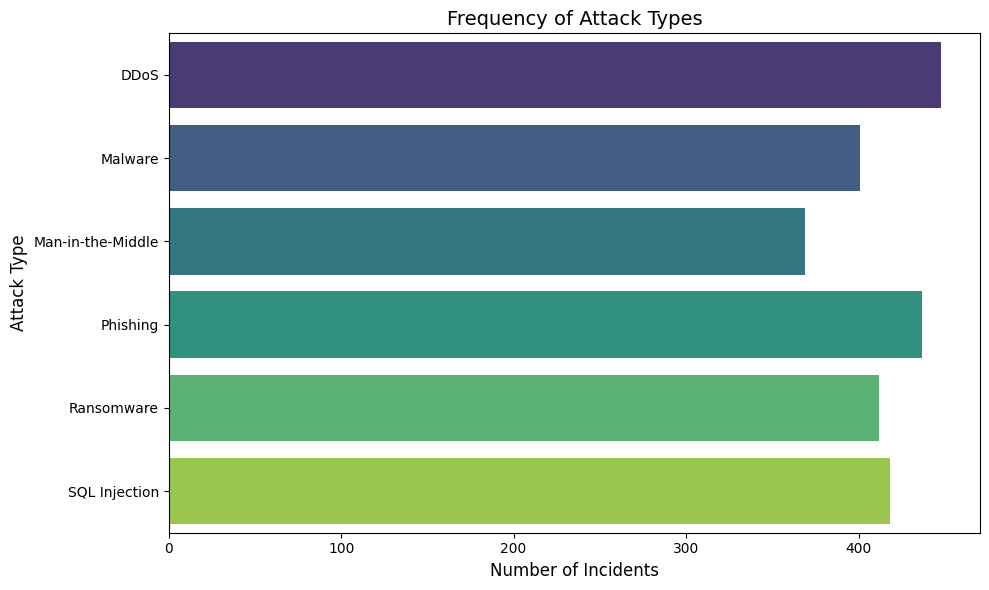

In [13]:
# Nhóm dữ liệu theo Loại Tấn Công để tính tổng số vụ tấn công
attack_type_frequency = cybersec_cleaned.groupby('Attack Type').size().reset_index(name='Number of Incidents')


# Vẽ biểu đồ cột ngang để hiển thị tần suất các loại tấn công
plt.figure(figsize=(10, 6))
sns.barplot(data=attack_type_frequency, x='Number of Incidents', y='Attack Type', palette='viridis')
plt.title('Frequency of Attack Types', fontsize=14)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_9732\739215278.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attack_by_country = cybersec_cleaned.groupby(['Country', 'Attack Type']).size().unstack(fill_value=0)


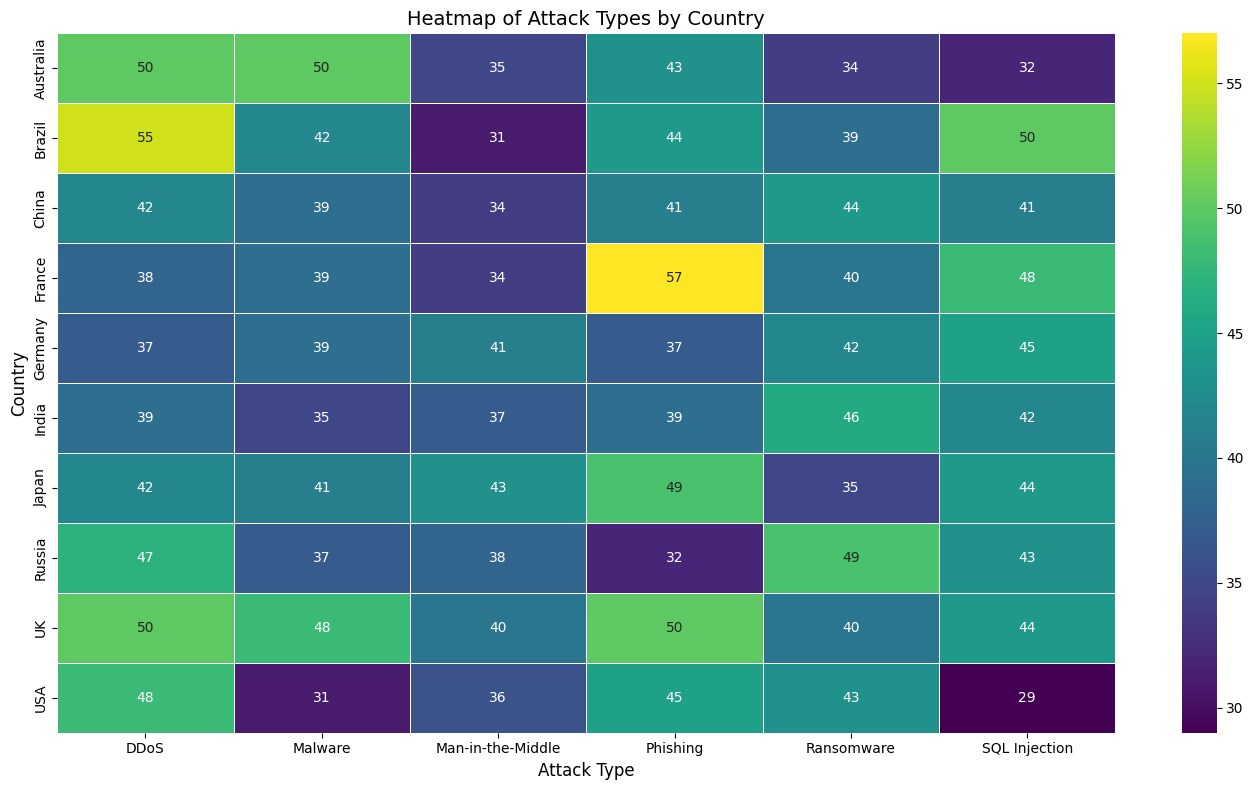

In [16]:
# Nhóm dữ liệu theo Quốc Gia và Loại Tấn Công để tính tổng số vụ tấn công
attack_by_country = cybersec_cleaned.groupby(['Country', 'Attack Type']).size().unstack(fill_value=0)

# Vẽ heatmap để hiển thị số lượng vụ tấn công theo quốc gia và loại tấn công
plt.figure(figsize=(14, 8))
sns.heatmap(attack_by_country, annot=True, fmt='d', cmap='viridis', linewidths=0.5)
plt.title('Heatmap of Attack Types by Country', fontsize=14)
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_9732\4136298419.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attack_type_losses = cybersec_cleaned.groupby('Attack Type')['Financial Loss (in Million $)'].mean().reset_index()
C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_9732\4136298419.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=attack_type_losses, x='Financial Loss (in Million $)', y='Attack Type', palette='viridis')


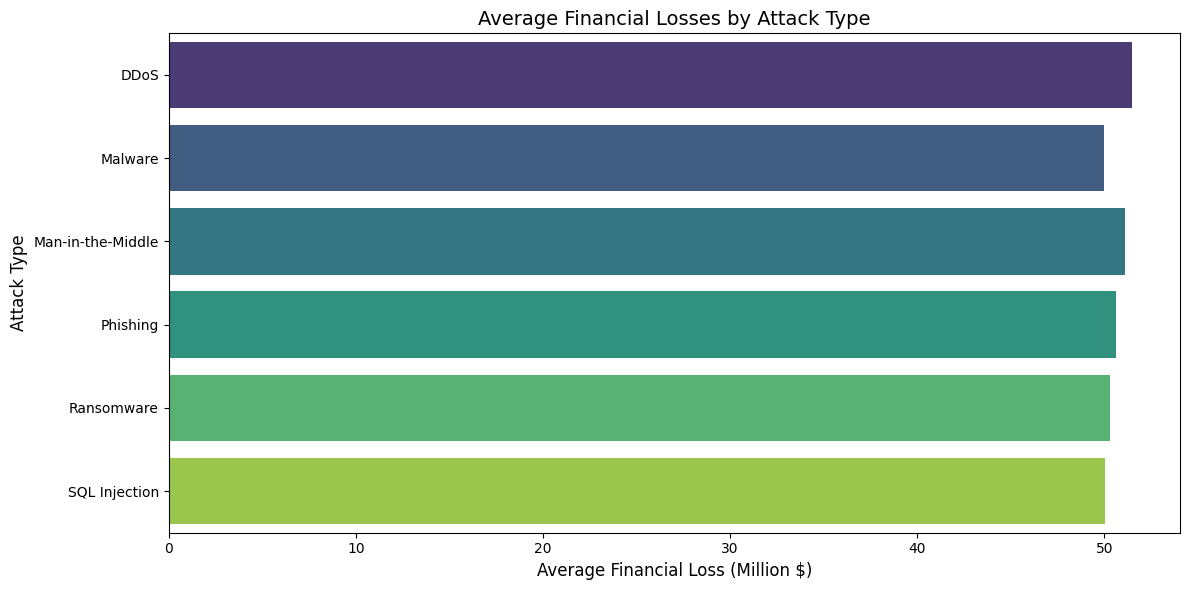

In [17]:
# Tính trung bình thiệt hại tài chính theo loại tấn công
attack_type_losses = cybersec_cleaned.groupby('Attack Type')['Financial Loss (in Million $)'].mean().reset_index()


# Sắp xếp giảm dần theo thiệt hại tài chính trung bình
attack_type_losses = attack_type_losses.sort_values(by='Financial Loss (in Million $)', ascending=False)


# Vẽ biểu đồ cột ngang để hiển thị loại tấn công gây thiệt hại tài chính trung bình cao nhất
plt.figure(figsize=(12, 6))
sns.barplot(data=attack_type_losses, x='Financial Loss (in Million $)', y='Attack Type', palette='viridis')
plt.title('Average Financial Losses by Attack Type', fontsize=14)
plt.xlabel('Average Financial Loss (Million $)', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.tight_layout()
plt.show()


Bo sung cua Cam Lan 

Mày nói tao xấu oke tao chấp nhận